# (1) 데이터 준비

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim import models

#ko_model  = models.Word2Vec.load("./ko.bin")

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/AIFFEL/Exploration_4/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/AIFFEL/Exploration_4/sentiment_classification/ratings_test.txt')

train_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/aiffel-dj53/AIFFEL/Exploration_4/sentiment_classification/ratings_train.txt'

In [ ]:
train_data.shape

# (2) 데이터 로더 구성

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print(X_train[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [7]:
print(X_train[1])

[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]


In [8]:
print(y_train[0])

0


In [9]:
get_decoded_sentence(X_train[0], index_to_word)

'더 빙 . . 진짜 짜증 나 네요 목소리'

# (3) 문장 길이 조절

## 1. 문장 길이 구하기

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### ↳ 적절한 문장길이는 maxlen값인 41로 지정해준다.


## 2. 패딩

In [11]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


# (4) 모델 설계

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

# (5) Val set 구성

In [13]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

# (6) 학습

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 9s 33ms/step - loss: 0.4750 - accuracy: 0.7624 - val_loss: 0.3476 - val_accuracy: 0.8485
Epoch 2/4
266/266 [==============================] - 1s 5ms/step - loss: 0.3221 - accuracy: 0.8629 - val_loss: 0.3303 - val_accuracy: 0.8568
Epoch 3/4
266/266 [==============================] - 1s 5ms/step - loss: 0.2876 - accuracy: 0.8803 - val_loss: 0.3271 - val_accuracy: 0.8569
Epoch 4/4
266/266 [==============================] - 1s 5ms/step - loss: 0.2560 - accuracy: 0.8970 - val_loss: 0.3341 - val_accuracy: 0.8585


# (7) 평가

In [15]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3489 - accuracy: 0.8505
[0.348929226398468, 0.8504587411880493]


### ↳ 20 Epochs로 학습시켰을때 0.82 수준의 적중률을 보여줬었다. 그래프를 확인해보니 4 Epochs부터 이격이 발생하는것을 확인하여 조정해주었더니 0.85로 향상된 값을 보인다.

In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Loss, Accuracy 그래프 시각화

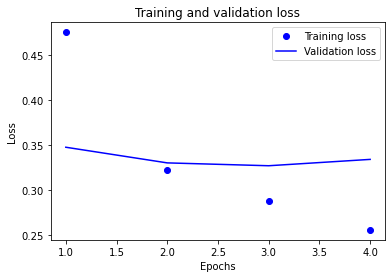

In [17]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

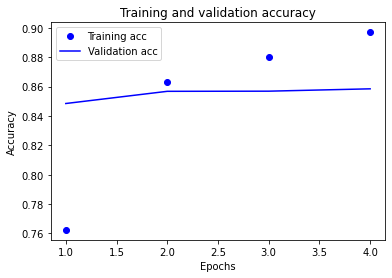

In [18]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# (8) Embedding Layer 분석

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/AIFFEL/Exploration_4/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재밌']
vector

array([-0.13037156, -0.10414363, -0.04945229,  0.22141203, -0.02579536,
       -0.10228854, -0.09141254, -0.0905773 , -0.11386103,  0.00330744,
        0.16239224,  0.02321851,  0.12098683, -0.05200464,  0.03468543,
        0.06795429], dtype=float32)

In [23]:
word_vectors.similar_by_word("짜증")

[('엎', 0.95551598072052),
 ('늘리', 0.944889485836029),
 ('반말', 0.942953884601593),
 ('원주율', 0.9365582466125488),
 ('어색', 0.9363012313842773),
 ('작자', 0.9361405372619629),
 ('빵점', 0.9345703721046448),
 ('다지만', 0.9306347370147705),
 ('과유불급', 0.9295171499252319),
 ('요가', 0.9266011714935303)]

### ↳'짜증'이라는 단어와 유사한 단어들이 전반적으로 부정적인 의미를 담고있긴하다. 하지만 유사함과는 거리가 멀어보인다.

# (9) Word2Vec

In [4]:
import os
from gensim import models
word2vec_path = os.getenv('HOME')+'/AIFFEL/Exploration_4/sentiment_classification/ko.bin'
ko_model = models.Word2Vec.load(word2vec_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/aiffel-dj53/AIFFEL/Exploration_4/sentiment_classification/ko.bin'

In [28]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
ko_model.similar_by_word("짜증")

/home/aiffel-dj53/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('싫증', 0.7431163787841797),
 ('흠집', 0.5909335613250732),
 ('흉내', 0.5880371928215027),
 ('아물', 0.5121865272521973),
 ('울음소리', 0.5063954591751099),
 ('탄로', 0.4944569766521454),
 ('그러', 0.4920297861099243),
 ('내보', 0.48765820264816284),
 ('악취', 0.48633819818496704),
 ('이거', 0.48398828506469727)]

### ↳임베딩보다는 보다 유사한 의미를 담고있는 단어들을 나열한다.

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj53/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj53/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# (9) Model2: Word2vec 적용

In [3]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid')) 

model2.summary()

NameError: name 'embedding_matrix' is not defined

In [31]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 12s 44ms/step - loss: 0.5627 - accuracy: 0.6867 - val_loss: 0.4323 - val_accuracy: 0.8019
Epoch 2/4
266/266 [==============================] - 7s 25ms/step - loss: 0.3850 - accuracy: 0.8278 - val_loss: 0.3634 - val_accuracy: 0.8371
Epoch 3/4
266/266 [==============================] - 6s 24ms/step - loss: 0.3264 - accuracy: 0.8595 - val_loss: 0.3438 - val_accuracy: 0.8512
Epoch 4/4
266/266 [==============================] - 7s 25ms/step - loss: 0.2918 - accuracy: 0.8783 - val_loss: 0.3435 - val_accuracy: 0.8494


### ↳ 5 Epochs부터 loss값이 증가해서 4 Epohs로 지정해줬다.

In [32]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3629 - accuracy: 0.8434
[0.36287322640419006, 0.8433793783187866]


### ↳ word2vec을 이용하였지만 오히려 성능이 근소하게 떨어진다.

In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


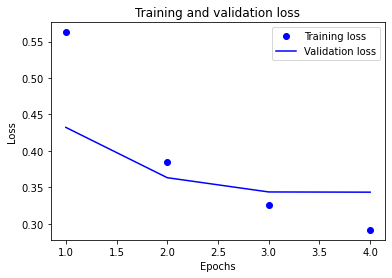

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

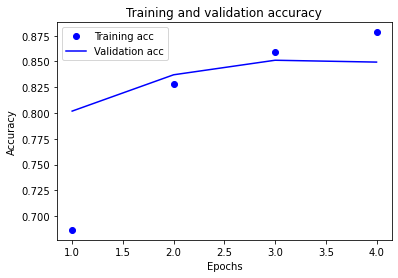

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

## 1. 자연어 처리라는 개념을 익히게 되었고 어떠한 식으로 진행되는지 감을 잡을 수 있었다.

## 2. 데이터 전처리에서 어떠한 기준으로 문장길이를 설정하는지, 해당 길이로 패딩을 진행하는 법 등을 배울수 있었다.

## 3. Embedded Layer기법에서 85%정도의 성능이 나왔는데 word2vec에선 오히려 떨어진 성능을 보여줬다. word2vec모델의 성능을 향상시키기 위해선 레이어 조정을 하거나 val set을 다시 조절해야 할 것 같다.

## 4. 이번 프로젝트에서 성능 그래프를 통해 어느 구간에서 과적합이 일어나고 적절한 Epochs를 찾는 법을 알게되어 의미가 큰 것 같다.

## 5. 컨텐츠 내용의 난이도에 비해 노드의 설명이 부족했던 프로젝트였던것같다. 어떻게던 이해를 해보려고 노드를 처음부터 끝까지 여러번 정독하였지만 프로젝트를 진행할땐 이해가 안가 힘들었다.